<style>
    .text_cell_render
    font-family: Times New Roman, serif
    </style>
    <font color='Black'><font size="5">Encontrar modelo de distribucion de la  senal de MNase-coupled a Gcn4 y predecir posibles interacciones de Gcn4 con dif erentes CoActivators</font>

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from numpy import NaN, Inf, arange, isscalar, asarray, array

/home/ariel/.local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">Dictionary of Roman Numbers. Will be used to access each chromosome faster</font>

In [2]:
roman_numbers = {'I':'1','II':'2','III':'3','IV':'4','V':'5','VI':'6','VII':'7',\
                 'VIII':'8','IX':'9','X':'10','XI':'11','XII':'12','XIII':'13','XIV':'14',\
                 'XV':'15','XVI':'16','XVII':'17','M':'M'}

inv_roman = {v: k for k, v in roman_numbers.iteritems()}

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Definir el promoter length y abrir SGD dataset</font>

In [3]:
def open_sgd(promoter_length):

    # open sgd file into a dataframe
    sgd = pd.read_csv('./SGD.tsv', delimiter='\t')

    #assign column names and use only the 'ORF' rows
    sgd.columns = ['n0','ORF_or_what','n1','locus','gene','n2','n3','n4'\
                  ,'chromosome','start','stop','W/C','n5','n6','n7','n8']
    sgd = sgd[sgd['ORF_or_what']=='ORF']
    
    # get rid of non-informative columns and 2-micron chromosome
    sgd = sgd.drop(['ORF_or_what','n0','n1','n2','n3','n4','n5','n6','n7','n8'],1).set_index('locus')
    sgd = sgd.ix[sgd.chromosome!='2-micron']

    # -1 to Creek and 1 to Watson
    sgd.loc[sgd['W/C']=='C', 'W/C']=-1
    sgd.loc[sgd['W/C']=='W', 'W/C']=1
    
    # create the column 'start promoter' and replace negative numbers \
    # with 0 (promoters that are <600bp form the start of the chromosome)
    sgd['start_promoter'] = sgd['start']-(sgd['W/C']*promoter_length)
    sgd.loc[sgd['start_promoter']<0,'start_promoter']=0

    #sgd['promoter_median'] = (sgd['start'] + sgd['start_promoter']) / 2
    #sgd = sgd.sort_values(['chromosome','promoter_median'])
    #sgd.reset_index(inplace=True)
    
    return sgd

In [32]:
sgd = open_sgd(600)
sgd = sgd[sgd.chromosome.isin(map(str,range(1,17)))]

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Abrir wiggle file</font>

In [37]:
def open_wig(wigfile):

# Open the wig file and make a pointer to where each chromosomes start
    #wig, w_pointer = [i.strip('\n').split('\t')[:2] for i in open(wigfile)], {} # this was for opening files, not from github  
    wig, w_pointer = wigfile, {}
    wig2, n = [], 0
    for i in wig[1:]:
        if len(i)==1:
            w_pointer[roman_numbers[i[0][22:]]] = n

        else:
            if int(i[1])>=0:                   ## era >=20...
                wig2.append(i)
                n+=1
        
    # the last pointer to the end of the file, when looking for a gene in chromosome 17 and there is no NEXT chromosome
    #w_pointer['17']=n 

    # wig into dataframe
    wig = pd.DataFrame(wig2)
    wig.columns = ['position','reads']

    return wig, w_pointer

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Dado el locus, devuelve los counts de wiggle</font>

In [5]:
def retrieve_positions(locus, sgd, wig, w_pointer):

    # chromosomes as pointer for the wig file
    this_chromosome = int(sgd[sgd.index==locus].values[0][1])
    this = w_pointer[str(this_chromosome)]

    # assign the key to NOT to be the current chromosome
    key = [1 if this_chromosome>7 else 10][0]

    # Now go and find me the closest chromosome in the wig file (they are not in order!!)
    for i,j in w_pointer.iteritems():
        if j-this < abs(w_pointer[str(key)]-this) and j>this and i != this_chromosome:
            key = i 
    next = w_pointer[str(key)]

    # promoter positions to find in the wig 
    promoter_positions = [int(i) for i in sgd[sgd.index==locus][['start_promoter', 'start']].as_matrix()[0]]
    
    # In case the gene is in the Creek direction
    if sgd[sgd.index==locus]['W/C'].values[0]==-1:
        promoter_positions = [promoter_positions[1],promoter_positions[0]]

    # restricting the wig to the chromosome and the positions 
    Gene_df =  wig[(wig.index > this) & (wig.index < next)]

    # Only if the wig file contains counts for this gene, otherwise return False!
    if Gene_df.position.empty == False:
        Gene_df = Gene_df[(Gene_df.position.astype(int)>promoter_positions[0]) & (Gene_df.position.astype(int)<promoter_positions[1])]
        return Gene_df.astype(int)
    else:
        return pd.DataFrame([])

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Lee archivo de Github</font>

In [6]:
def getFromGit(link):
    
        from html2text import html2text
        import requests
    
        f = requests.get(link)
    
        return f.text.encode('ascii','replace')

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Busco la bw optima para el kernel</font>

In [66]:
def find_Kernel_best_bandwidth(x,y):

    # Prepare "histogram-like" data
    histo = []
    for i in range(len(y)):
        for j in range(y[i]):
            histo.append(x[i])
    histo = np.array(histo)

    #Check which is the best bandwidth to use with 20 steps of cross-validation
    grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(10,100,10)}, cv=9)
    grid.fit(histo[:,None])

    return grid.best_params_.values()[0]

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: devuelve PDF</font>

In [65]:
def kernelPDF(x, y, bandwidth=50, kernel_choose='epanechnikov'):

    # Prepare "histogram-like" data
    histo = []
    for i in range(len(y)):
        for j in range(y[i]):
            histo.append(x[i])

    histo = np.array(histo)
    
    # Kernel Density Estimation with Scikit-learn
    kde = KernelDensity(kernel=kernel_choose, bandwidth=bandwidth).fit(histo[:,np.newaxis])
    pdf = np.exp(kde.score_samples(x[:,np.newaxis]))*10000
        
    return pdf

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">Leo wiggle de Github y lo almaceno en una df</font>

In [38]:
wig = getFromGit('https://raw.githubusercontent.com/aerijman/gcn4_ChEC/master/extremes_27.wig')

mat=[]
for i in wig.split('\n'):
    mat.append(i.strip().split('\t')[:2])
    
df_wig, pointer_wig = open_wig(mat[:-1])

locus
YCL009C    -1
Name: W/C, dtype: object


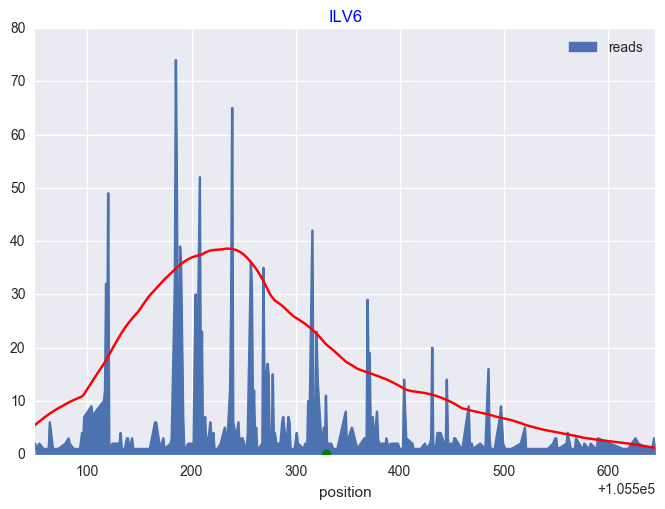

In [115]:
gene = 'ILV6'
gene_df = retrieve_positions(sgd[sgd.gene==gene].index[0], sgd, df_wig, pointer_wig)
print sgd.loc[sgd.gene==gene, 'W/C']

(x,y) =  zip(*[(i[0], i[1]) for i in gene_df[['position','reads']].values])
x,y = np.array(x, dtype=int), np.array(y, dtype=int)
best_bw = find_Kernel_best_bandwidth(x,y)
kernel = kernelPDF(x,y,90)

gene_df.plot.area(x='position', y='reads')
plt.plot(x,kernel, color="r")
plt.title(gene, color='b')
xx,yy = 105829, 60
plt.plot(xx,yy, "o", color='g')